# MPO Pitch Control for LIGO Suspensions

This notebook trains a Maximum a Posteriori Policy Optimization (MPO) agent to control pitch dynamics of LIGO test masses. It includes:
- **CHARD plant model** from `CHARD-plant-fit-params.npz` (quadruple pendulum + radiation pressure)
- Real LIGO noise injection from HDF5 files
- Seismic and sensor noise injection
- Training with deep loop shaping reward
- Evaluation with noise analysis
- Strain sensitivity calculation

## Plant Model
The CHARD (Common Hard) pitch plant model contains:
- **Stable poles at ~1 Hz**: Quadruple pendulum mechanical resonance
- **Unstable poles at ~2.4 Hz**: Radiation pressure instability (RHP poles)
- This makes the system inherently unstable and challenging for RL controllers

In [1]:
# =============================================================================
# Imports and Setup
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
from gymnasium import spaces
from scipy import signal
from scipy.signal import zpk2ss, cont2discrete, tf2ss, welch, butter, lfilter, lfilter_zi, find_peaks, sosfilt
from scipy.linalg import solve_discrete_are
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sampling frequency
fs = 256  # Hz
dt = 1.0 / fs
print(f"Sampling frequency: {fs} Hz, dt = {dt:.6f} s")

Using device: cpu
Sampling frequency: 256 Hz, dt = 0.003906 s


In [2]:
# =============================================================================
# Load Transfer Functions and REAL Noise Data from LIGO
# =============================================================================
import h5py
from scipy.signal import resample

tf_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/transfer_functions/'
noise_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/noise_inputs/'
hdf5_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/hdf5/'

def load_tf_csv(filepath):
    """Load transfer function from CSV file (frequency, complex value)"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            freq = float(parts[0])
            complex_val = complex(parts[1].replace('j', 'j'))
            data.append((freq, complex_val))
    freqs = np.array([d[0] for d in data])
    H = np.array([d[1] for d in data])
    return freqs, H

def load_noise_file(filepath):
    """Load noise ASD file, auto-detecting comma or space delimiter"""
    with open(filepath, 'r') as f:
        first_line = f.readline()
    if ',' in first_line:
        data = np.loadtxt(filepath, delimiter=',')
    else:
        data = np.loadtxt(filepath)
    return data[:, 0], data[:, 1]

# Load all three transfer functions
freq_L, H_topL = load_tf_csv(tf_path + 'tf_topL_2_tstP.csv')
freq_NL, H_topNL = load_tf_csv(tf_path + 'tf_topNL_2_tstP.csv')
freq_NP, H_topNP = load_tf_csv(tf_path + 'tf_topNP_2_tstP.csv')

# Load ASD specifications (for reference/comparison plots)
freq_sei_asd, sei_asd_ref = load_noise_file(noise_path + 'ETM_SEI_LIGO_O3.csv')
freq_sensor, sensor_noise_asd_raw = load_noise_file(noise_path + 'SENSOR_PITCH_HARD.csv')

# =============================================================================
# Load REAL Time-Domain Noise from LIGO HDF5 Files
# =============================================================================
print("Loading REAL LIGO noise data from HDF5...")

with h5py.File(hdf5_path + 'L1_1407160711.hdf5', 'r') as f:
    # Load the pitch error signal - this contains real sensor noise + seismic effects
    real_noise_raw = f['L1:SBR-CHARD_P_ERR_OUT_DQ'][:]
    real_noise_fs_original = 1.0 / f['L1:SBR-CHARD_P_ERR_OUT_DQ'].attrs['dx']
    
print(f"\\nReal LIGO noise loaded:")
print(f"  Original sample rate: {real_noise_fs_original:.0f} Hz")
print(f"  Total samples: {len(real_noise_raw):,}")
print(f"  Duration: {len(real_noise_raw)/real_noise_fs_original:.1f} seconds ({len(real_noise_raw)/real_noise_fs_original/60:.1f} minutes)")

# Resample to our target sample rate (256 Hz)
resample_factor = int(real_noise_fs_original / fs)
real_noise_resampled = real_noise_raw[::resample_factor]  # Simple decimation (assuming anti-aliasing)

print(f"\\nResampled to {fs} Hz:")
print(f"  Samples: {len(real_noise_resampled):,}")
print(f"  Duration: {len(real_noise_resampled)/fs:.1f} seconds")
print(f"  RMS: {np.std(real_noise_resampled):.3e}")

# Normalize/scale the real noise (it's in arbitrary units, scale to match our simulation)
# The real noise will be used as the disturbance input
real_noise_scale = 1e-9  # Scale factor to convert to appropriate physical units
real_noise = real_noise_resampled * real_noise_scale

print(f"  Scaled RMS: {np.std(real_noise):.3e}")

print("\\nTransfer Functions Loaded:")
print(f"  tf_topL_2_tstP: {len(freq_L)} points, {freq_L[0]:.4f}-{freq_L[-1]:.2f} Hz")
print(f"  tf_topNL_2_tstP: {len(freq_NL)} points")
print(f"  tf_topNP_2_tstP: {len(freq_NP)} points")

Loading REAL LIGO noise data from HDF5...
\nReal LIGO noise loaded:
  Original sample rate: 2048 Hz
  Total samples: 9,926,656
  Duration: 4847.0 seconds (80.8 minutes)
\nResampled to 256 Hz:
  Samples: 1,240,832
  Duration: 4847.0 seconds
  RMS: 2.745e+01
  Scaled RMS: 2.745e-08
\nTransfer Functions Loaded:
  tf_topL_2_tstP: 1000 points, 0.0100-256.00 Hz
  tf_topNL_2_tstP: 1000 points
  tf_topNP_2_tstP: 1000 points


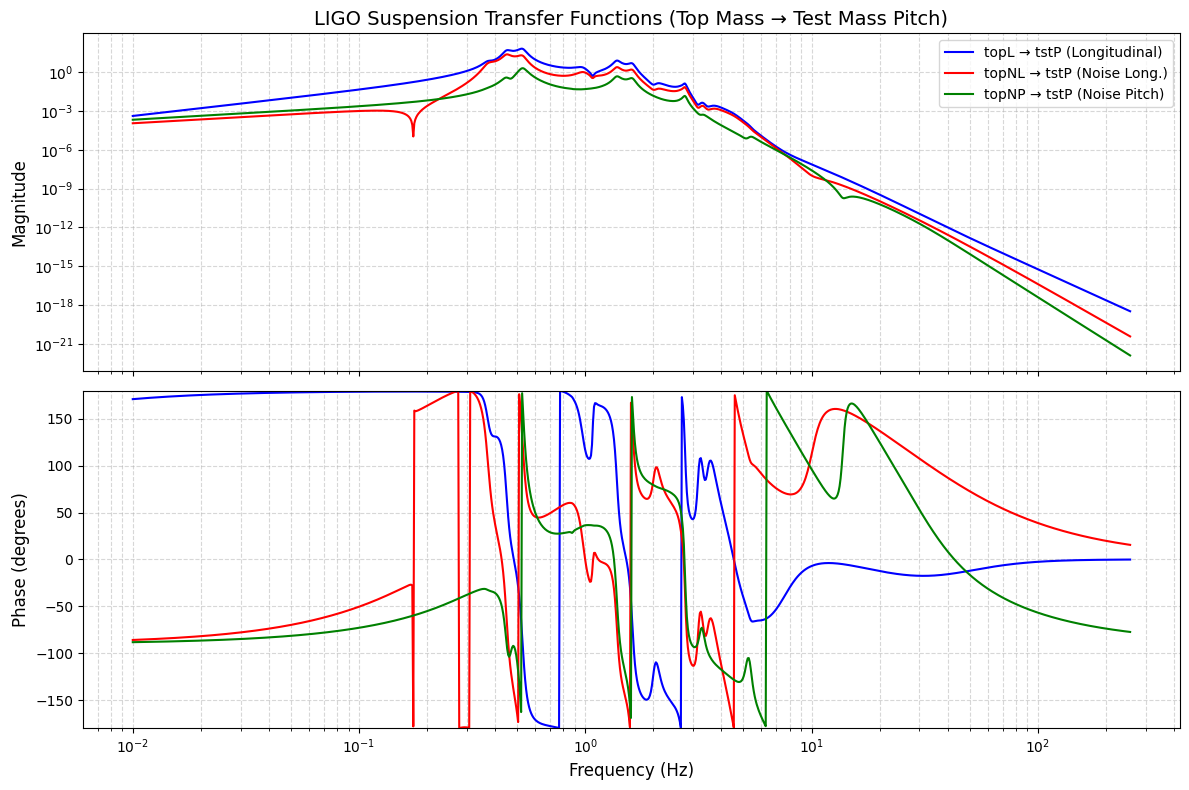

In [3]:
# =============================================================================
# Plot Transfer Functions (Bode Plots)
# =============================================================================
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Magnitude plot
ax1 = axes[0]
ax1.loglog(freq_L, np.abs(H_topL), 'b-', linewidth=1.5, label='topL → tstP (Longitudinal)')
ax1.loglog(freq_NL, np.abs(H_topNL), 'r-', linewidth=1.5, label='topNL → tstP (Noise Long.)')
ax1.loglog(freq_NP, np.abs(H_topNP), 'g-', linewidth=1.5, label='topNP → tstP (Noise Pitch)')
ax1.set_ylabel('Magnitude', fontsize=12)
ax1.set_title('LIGO Suspension Transfer Functions (Top Mass → Test Mass Pitch)', fontsize=14)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Phase plot
ax2 = axes[1]
ax2.semilogx(freq_L, np.angle(H_topL, deg=True), 'b-', linewidth=1.5)
ax2.semilogx(freq_NL, np.angle(H_topNL, deg=True), 'r-', linewidth=1.5)
ax2.semilogx(freq_NP, np.angle(H_topNP, deg=True), 'g-', linewidth=1.5)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Phase (degrees)', fontsize=12)
ax2.grid(True, which='both', linestyle='--', alpha=0.5)
ax2.set_ylim([-180, 180])

plt.tight_layout()
plt.show()

In [4]:
# =============================================================================
# Load CHARD Plant Model from NPZ File
# =============================================================================
# The CHARD-plant-fit-params.npz contains the fitted plant model:
# - z_p3: zeros (empty for this plant)
# - p_p3: poles (complex conjugate pairs)
# - k_p3: gain

plant_npz_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/hdf5/CHARD-plant-fit-params.npz'

# Load plant parameters
plant_params = np.load(plant_npz_path, allow_pickle=True)
plant_zeros = plant_params['z_p3']
plant_poles = plant_params['p_p3']
plant_gain = float(plant_params['k_p3'])

print("=" * 60)
print("CHARD Plant Model (from CHARD-plant-fit-params.npz)")
print("=" * 60)
print(f"\nPlant zeros: {plant_zeros if len(plant_zeros) > 0 else 'None (empty array)'}")
print(f"Plant poles:")
for i, pole in enumerate(plant_poles):
    freq_hz = np.abs(np.imag(pole)) / (2 * np.pi)
    stability = "UNSTABLE (RHP)" if np.real(pole) > 0 else "Stable"
    print(f"  p_{i+1}: {pole:.6f} → {freq_hz:.2f} Hz ({stability})")
print(f"Plant gain: {plant_gain}")

# Convert zeros-poles-gain to continuous-time state-space
# Using scipy.signal.zpk2ss
if len(plant_zeros) == 0:
    # No zeros case - create transfer function from poles and gain
    den_coeffs = np.real(np.poly(plant_poles))
    num_coeffs = np.array([plant_gain])
    A_plant_c, B_plant_c, C_plant_c, D_plant_c = tf2ss(num_coeffs, den_coeffs)
else:
    A_plant_c, B_plant_c, C_plant_c, D_plant_c = zpk2ss(plant_zeros, plant_poles, plant_gain)

print(f"\nContinuous state-space model:")
print(f"  State dimension: {A_plant_c.shape[0]}")

# Discretize using bilinear (Tustin) transform for numerical stability
plant_sys_d = cont2discrete((A_plant_c, B_plant_c, C_plant_c, D_plant_c), dt, method='bilinear')
A_plant, B_plant, C_plant, D_plant = plant_sys_d[0], plant_sys_d[1], plant_sys_d[2], plant_sys_d[3]

print(f"\nDiscrete state-space (fs = {fs} Hz, dt = {dt:.6f} s):")
print(f"  State dimension: {A_plant.shape[0]}")

# Check stability of discrete system
eigs = np.linalg.eigvals(A_plant)
print(f"\nDiscrete eigenvalues (stability check):")
n_unstable = 0
for i, e in enumerate(eigs):
    mag = np.abs(e)
    status = "UNSTABLE" if mag > 1 else "stable"
    if mag > 1:
        n_unstable += 1
    print(f"  λ_{i+1}: |{mag:.6f}| ({status})")

if n_unstable > 0:
    print(f"\n*** WARNING: {n_unstable} unstable mode(s) detected! ***")
    print("This is expected for the CHARD model (radiation pressure instability at ~2.4 Hz)")

# Store for environment
plant_model = {
    'A': A_plant, 'B': B_plant, 'C': C_plant, 'D': D_plant,
    'n_states': A_plant.shape[0], 'dt': dt, 'fs': fs,
    'poles': plant_poles, 'zeros': plant_zeros, 'gain': plant_gain
}

# Sensor noise level (flat ASD)
sensor_noise_level = np.mean(sensor_noise_asd_raw)
print(f"\nSensor noise (SENSOR_PITCH_HARD): {sensor_noise_level:.2e} rad/√Hz")

CHARD Plant Model (from CHARD-plant-fit-params.npz)

Plant zeros: None (empty array)
Plant poles:
  p_1: -0.188496+6.534513j → 1.04 Hz (Stable)
  p_2: -0.188496-6.534513j → 1.04 Hz (Stable)
  p_3: 0.408407+15.079645j → 2.40 Hz (UNSTABLE (RHP))
  p_4: 0.408407-15.079645j → 2.40 Hz (UNSTABLE (RHP))
Plant gain: 80.0

Continuous state-space model:
  State dimension: 4

Discrete state-space (fs = 256 Hz, dt = 0.003906 s):
  State dimension: 4

Discrete eigenvalues (stability check):
  λ_1: |1.001595| (UNSTABLE)
  λ_2: |1.001595| (UNSTABLE)
  λ_3: |0.999264| (stable)
  λ_4: |0.999264| (stable)

*** WARNING: 2 unstable mode(s) detected! ***
This is expected for the CHARD model (radiation pressure instability at ~2.4 Hz)

Sensor noise (SENSOR_PITCH_HARD): 3.00e-14 rad/√Hz


In [5]:
# =============================================================================
# Deep Loop Shaping Reward Function
# =============================================================================

class BandEnergyTracker:
    """Track band-limited energy using causal Butterworth filters and EMA"""
    
    def __init__(self, fs, ema_alpha=0.01):
        self.fs = fs
        self.ema_alpha = ema_alpha
        
        # Design Butterworth filters for three frequency bands
        self.b_low, self.a_low = butter(2, 3.0 / (fs/2), btype='low')
        self.b_mid, self.a_mid = butter(2, [8.0 / (fs/2), 30.0 / (fs/2)], btype='band')
        self.b_high, self.a_high = butter(2, 40.0 / (fs/2), btype='high')
        
        self.reset()
    
    def reset(self):
        """Reset filter states and energy estimates"""
        self.zi_low = lfilter_zi(self.b_low, self.a_low) * 0
        self.zi_mid = lfilter_zi(self.b_mid, self.a_mid) * 0
        self.zi_high = lfilter_zi(self.b_high, self.a_high) * 0
        
        self.energy_low = 0.0
        self.energy_mid = 0.0
        self.energy_high = 0.0
    
    def update(self, signal_sample):
        """Update band energies with new sample"""
        y_low, self.zi_low = lfilter(self.b_low, self.a_low, [signal_sample], zi=self.zi_low)
        y_mid, self.zi_mid = lfilter(self.b_mid, self.a_mid, [signal_sample], zi=self.zi_mid)
        y_high, self.zi_high = lfilter(self.b_high, self.a_high, [signal_sample], zi=self.zi_high)
        
        self.energy_low = (1 - self.ema_alpha) * self.energy_low + self.ema_alpha * y_low[0]**2
        self.energy_mid = (1 - self.ema_alpha) * self.energy_mid + self.ema_alpha * y_mid[0]**2
        self.energy_high = (1 - self.ema_alpha) * self.energy_high + self.ema_alpha * y_high[0]**2
        
        return self.energy_low, self.energy_mid, self.energy_high


def deep_loop_shaping_reward(energy_low, energy_mid, energy_high,
                              alpha_low=1e12, beta_low=1e-24,
                              alpha_mid=1e14, beta_mid=1e-28,
                              alpha_high=1e16, beta_high=1e-32):
    """Compute Deep Loop Shaping reward as product of sigmoid scores"""
    score_low = 1.0 / (1.0 + np.exp(alpha_low * (energy_low - beta_low)))
    score_mid = 1.0 / (1.0 + np.exp(alpha_mid * (energy_mid - beta_mid)))
    score_high = 1.0 / (1.0 + np.exp(alpha_high * (energy_high - beta_high)))
    
    reward = score_low * score_mid * score_high
    return reward, (score_low, score_mid, score_high)


print("Deep Loop Shaping Reward Function Initialized")
print("  Low band:  < 3 Hz  (stability)")
print("  Mid band:  8-30 Hz (sensor noise rejection)")
print("  High band: > 40 Hz (robustness)")

Deep Loop Shaping Reward Function Initialized
  Low band:  < 3 Hz  (stability)
  Mid band:  8-30 Hz (sensor noise rejection)
  High band: > 40 Hz (robustness)


In [6]:
# =============================================================================
# Colored Noise Generation from ASD (kept for reference, but using real noise)
# =============================================================================

def generate_colored_noise(asd_freq, asd_values, fs, n_samples):
    """Generate colored noise from ASD using frequency-domain method"""
    freqs_fft = np.fft.rfftfreq(n_samples, d=1/fs)
    asd_interp = np.interp(freqs_fft, asd_freq, asd_values, left=asd_values[0], right=asd_values[-1])
    psd_interp = asd_interp**2
    magnitude = np.sqrt(psd_interp * n_samples / 2)
    phase = np.random.uniform(0, 2*np.pi, len(freqs_fft))
    spectrum = magnitude * np.exp(1j * phase)
    spectrum[0] = 0  # DC component = 0
    noise = np.fft.irfft(spectrum, n=n_samples)
    return noise

print("Colored noise generator ready (for synthetic noise)")
print("\\n*** NOTE: This notebook uses REAL LIGO noise data instead of synthetic noise! ***")

Colored noise generator ready (for synthetic noise)
\n*** NOTE: This notebook uses REAL LIGO noise data instead of synthetic noise! ***


In [7]:
# =============================================================================
# Pitch Control Environment with REAL Noise Injection
# IMPROVED: Better observations, baseline controller, and stability features
# =============================================================================

class PitchControlEnv(gym.Env):
    """LIGO Pitch Control Environment with REAL LIGO Noise Data
    
    IMPROVEMENTS for stability:
    1. Extended observation space with history and filtered signals
    2. Optional baseline PD controller for stability
    3. Better reward shaping for unstable plants
    """
    
    def __init__(self, plant_model, sensor_noise_level, real_noise_data, max_steps=2048,
                 use_baseline_controller=True, obs_history_len=8):
        super().__init__()
        
        self.A = plant_model['A']
        self.B = plant_model['B']
        self.C = plant_model['C']
        self.D = plant_model['D']
        self.n_states = plant_model['n_states']
        self.dt = plant_model['dt']
        self.fs = plant_model['fs']
        self.max_steps = max_steps
        
        # Store REAL noise data (time-domain)
        self.real_noise_data = real_noise_data
        self.noise_index = 0
        
        # Sensor noise
        self.sensor_noise_level = sensor_noise_level
        self.sensor_noise_std = sensor_noise_level * np.sqrt(self.fs)
        
        # Action scaling
        self.action_scale = 1e-6
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # IMPROVED: Extended observation with history
        self.obs_history_len = obs_history_len
        self.obs_scale = 1e-9
        # Observation: [current_error, error_derivative, filtered_error, action_history, error_history]
        obs_dim = 1 + 1 + 1 + obs_history_len + obs_history_len  # error, derivative, filtered, action_hist, error_hist
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        # IMPROVED: Baseline PD controller for stability
        self.use_baseline_controller = use_baseline_controller
        # PD gains tuned for the CHARD plant (stabilize ~2.4 Hz mode)
        self.Kp = -5e3  # Proportional gain (negative feedback)
        self.Kd = -1e3  # Derivative gain
        
        # Low-pass filter for derivative estimation
        self.deriv_alpha = 0.3  # EMA smoothing for derivative
        
        # Band energy tracker for reward
        self.band_tracker = BandEnergyTracker(self.fs, ema_alpha=0.02)
        
        # IMPROVED: Reward parameters tuned for unstable plant
        self.alpha_low = 1e16
        self.beta_low = 1e-16
        self.alpha_mid = 1e18
        self.beta_mid = 1e-18
        self.alpha_high = 1e20
        self.beta_high = 1e-20
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Initialize state with smaller perturbation
        self.x = np.random.randn(self.n_states, 1) * 1e-14
        self.step_count = 0
        self.band_tracker.reset()
        
        # Random starting position in noise data
        max_start = len(self.real_noise_data) - self.max_steps - 1
        if max_start > 0:
            self.noise_index = np.random.randint(0, max_start)
        else:
            self.noise_index = 0
        
        # History buffers
        self.error_history = deque([0.0] * self.obs_history_len, maxlen=self.obs_history_len)
        self.action_history = deque([0.0] * self.obs_history_len, maxlen=self.obs_history_len)
        self.prev_error = 0.0
        self.filtered_error = 0.0
        self.error_derivative = 0.0
        
        # Storage for plotting
        self.pitch_true_history = []
        self.pitch_measured_history = []
        self.torque_history = []
        self.seismic_history = []
        self.sensor_noise_history = []
        self.baseline_action_history = []
        self.rl_action_history = []
        
        # Get initial observation
        sensor_noise = self.sensor_noise_std * np.random.randn()
        y = (self.C @ self.x).flatten()[0] + sensor_noise
        obs = self._get_observation(y, 0.0)
        
        return obs, {}
    
    def _get_observation(self, error, action):
        """Construct extended observation vector"""
        # Update derivative estimate (EMA-smoothed)
        raw_derivative = (error - self.prev_error) * self.fs
        self.error_derivative = self.deriv_alpha * raw_derivative + (1 - self.deriv_alpha) * self.error_derivative
        self.prev_error = error
        
        # Update filtered error (low-pass)
        self.filtered_error = 0.1 * error + 0.9 * self.filtered_error
        
        # Update histories
        self.error_history.append(error / self.obs_scale)
        self.action_history.append(action)
        
        # Construct observation
        obs = np.concatenate([
            [error / self.obs_scale],                    # Current error (scaled)
            [self.error_derivative / self.obs_scale],   # Error derivative
            [self.filtered_error / self.obs_scale],     # Filtered error
            list(self.action_history),                   # Action history
            list(self.error_history)                     # Error history
        ]).astype(np.float32)
        
        return obs
    
    def _baseline_controller(self, error):
        """PD controller for baseline stabilization"""
        u_baseline = self.Kp * error + self.Kd * self.error_derivative
        # Clip to action limits
        u_baseline = np.clip(u_baseline, -self.action_scale, self.action_scale)
        return u_baseline
    
    def step(self, action):
        # RL action (normalized to [-1, 1])
        u_rl = action[0] * self.action_scale
        
        # IMPROVED: Combine baseline + RL action for stability
        if self.use_baseline_controller:
            # Get current error for baseline controller
            y_current = (self.C @ self.x).flatten()[0]
            u_baseline = self._baseline_controller(y_current)
            # Total control = baseline + RL correction (RL learns residual)
            u_total = u_baseline + u_rl * 0.5  # RL has smaller authority
        else:
            u_baseline = 0.0
            u_total = u_rl
        
        # Get REAL seismic disturbance
        current_idx = self.noise_index + self.step_count
        if current_idx < len(self.real_noise_data):
            seismic_disturbance = self.real_noise_data[current_idx]
        else:
            seismic_disturbance = self.real_noise_data[current_idx % len(self.real_noise_data)]
        
        # State update
        self.x = self.A @ self.x + self.B * (u_total + seismic_disturbance)
        
        # True output
        y_true = (self.C @ self.x + self.D * u_total).flatten()[0]
        
        # Add sensor noise
        sensor_noise = self.sensor_noise_std * np.random.randn()
        y_measured = y_true + sensor_noise
        
        # Store history
        self.pitch_true_history.append(y_true)
        self.pitch_measured_history.append(y_measured)
        self.torque_history.append(u_total)
        self.seismic_history.append(seismic_disturbance)
        self.sensor_noise_history.append(sensor_noise)
        self.baseline_action_history.append(u_baseline)
        self.rl_action_history.append(u_rl)
        
        # Update band energies and compute reward
        e_low, e_mid, e_high = self.band_tracker.update(y_measured)
        reward, scores = deep_loop_shaping_reward(
            e_low, e_mid, e_high,
            self.alpha_low, self.beta_low,
            self.alpha_mid, self.beta_mid,
            self.alpha_high, self.beta_high
        )
        
        # IMPROVED: Additional reward shaping for stability
        # Penalize large errors and reward staying near zero
        error_penalty = -np.abs(y_true) * 1e6  # Penalize deviation
        stability_bonus = 0.1 if np.abs(y_true) < 1e-9 else 0.0
        reward = reward + error_penalty * 0.001 + stability_bonus
        
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        truncated = False
        
        # Check for instability (more lenient threshold during training)
        if np.abs(y_true) > 1e-5:  # 10 µrad threshold
            terminated = True
            reward = -10.0  # Larger penalty for instability
        
        obs = self._get_observation(y_measured, action[0])
        
        info = {
            'y_true': y_true,
            'y_measured': y_measured,
            'torque': u_total,
            'u_baseline': u_baseline,
            'u_rl': u_rl,
            'seismic': seismic_disturbance,
            'sensor_noise': sensor_noise,
            'scores': scores,
            'energies': (e_low, e_mid, e_high)
        }
        
        return obs, reward, terminated, truncated, info


# Create environment with IMPROVED settings
env = PitchControlEnv(
    plant_model, 
    sensor_noise_level, 
    real_noise, 
    max_steps=2048,
    use_baseline_controller=True,  # Use PD baseline for stability
    obs_history_len=8
)

print(f"IMPROVED Environment created:")
print(f"  State dimension: {env.n_states}")
print(f"  Observation dimension: {env.observation_space.shape[0]}")
print(f"  Baseline controller: {'ENABLED (PD)' if env.use_baseline_controller else 'DISABLED'}")
print(f"  PD gains: Kp={env.Kp:.1e}, Kd={env.Kd:.1e}")
print(f"  Sensor noise std: {env.sensor_noise_std:.2e} rad")
print(f"  Max steps: {env.max_steps}")
print(f"\n  *** Using {len(real_noise):,} samples of REAL LIGO noise! ***")

IMPROVED Environment created:
  State dimension: 4
  Observation dimension: 19
  Baseline controller: ENABLED (PD)
  PD gains: Kp=-5.0e+03, Kd=-1.0e+03
  Sensor noise std: 4.80e-13 rad
  Max steps: 2048

  *** Using 1,240,832 samples of REAL LIGO noise! ***


In [ ]:
# =============================================================================
# MPO (Maximum a Posteriori Policy Optimization) Implementation
# IMPROVED: Larger networks for better learning capacity
# =============================================================================

class GaussianPolicy(nn.Module):
    """Gaussian policy network for continuous actions - IMPROVED with larger architecture"""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim // 2, action_dim)
        self.log_std_head = nn.Linear(hidden_dim // 2, action_dim)
        
    def forward(self, obs):
        h = self.net(obs)
        mean = torch.tanh(self.mean_head(h))
        log_std = torch.clamp(self.log_std_head(h), -5, 0)  # More conservative std
        return mean, log_std
    
    def sample(self, obs):
        mean, log_std = self.forward(obs)
        std = log_std.exp()
        dist = Normal(mean, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(-1)
        return torch.clamp(action, -1, 1), log_prob, mean
    
    def get_action(self, obs, deterministic=False):
        with torch.no_grad():
            mean, log_std = self.forward(obs)
            if deterministic:
                return mean.cpu().numpy()
            std = log_std.exp()
            action = Normal(mean, std).sample()
            return torch.clamp(action, -1, 1).cpu().numpy()


class QNetwork(nn.Module):
    """Q-value network - IMPROVED with larger architecture"""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=-1)
        return self.net(x)


class ReplayBuffer:
    """Simple replay buffer"""
    
    def __init__(self, capacity=100000):  # Larger buffer
        self.buffer = deque(maxlen=capacity)
    
    def push(self, obs, action, reward, next_obs, done):
        self.buffer.append((obs, action, reward, next_obs, done))
    
    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        obs, action, reward, next_obs, done = zip(*[self.buffer[i] for i in batch])
        return (
            torch.FloatTensor(np.array(obs)).to(device),
            torch.FloatTensor(np.array(action)).to(device),
            torch.FloatTensor(np.array(reward)).unsqueeze(1).to(device),
            torch.FloatTensor(np.array(next_obs)).to(device),
            torch.FloatTensor(np.array(done)).unsqueeze(1).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)


class MPO:
    """Maximum a Posteriori Policy Optimization - IMPROVED"""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=256, lr=1e-4,
                 gamma=0.99, eps_eta=0.1, eps_mean=0.1, eps_var=0.0001):
        
        self.gamma = gamma
        self.eps_eta = eps_eta
        self.eps_mean = eps_mean
        self.eps_var = eps_var
        
        # Networks - larger hidden dim
        self.policy = GaussianPolicy(obs_dim, action_dim, hidden_dim).to(device)
        self.q1 = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q2 = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q1_target = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q2_target = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        
        # Optimizers with lower learning rate for stability
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)
        
        # Lagrange multipliers
        self.log_eta = torch.zeros(1, requires_grad=True, device=device)
        self.log_alpha_mean = torch.zeros(1, requires_grad=True, device=device)
        self.log_alpha_var = torch.zeros(1, requires_grad=True, device=device)
        self.dual_optimizer = optim.Adam([self.log_eta, self.log_alpha_mean, self.log_alpha_var], lr=lr)
        
        self.buffer = ReplayBuffer(capacity=500000)
        self.action_dim = action_dim
        
    def update(self, batch_size=512, n_action_samples=20):
        if len(self.buffer) < batch_size:
            return {}
        
        obs, action, reward, next_obs, done = self.buffer.sample(batch_size)
        
        # Update Q-functions
        with torch.no_grad():
            next_action, next_log_prob, _ = self.policy.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)
            q_next = torch.min(q1_next, q2_next)
            target_q = reward + self.gamma * (1 - done) * q_next
        
        q1_loss = F.mse_loss(self.q1(obs, action), target_q)
        q2_loss = F.mse_loss(self.q2(obs, action), target_q)
        
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q1.parameters(), 1.0)  # Gradient clipping
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q2.parameters(), 1.0)
        self.q2_optimizer.step()
        
        # E-step: compute action weights
        with torch.no_grad():
            obs_expanded = obs.unsqueeze(1).expand(-1, n_action_samples, -1)
            obs_flat = obs_expanded.reshape(-1, obs.shape[-1])
            
            sampled_actions, _, _ = self.policy.sample(obs_flat)
            sampled_actions = sampled_actions.reshape(batch_size, n_action_samples, -1)
            
            q_values = torch.min(
                self.q1(obs_expanded.reshape(-1, obs.shape[-1]), sampled_actions.reshape(-1, self.action_dim)),
                self.q2(obs_expanded.reshape(-1, obs.shape[-1]), sampled_actions.reshape(-1, self.action_dim))
            ).reshape(batch_size, n_action_samples)
            
            eta = self.log_eta.exp().clamp(min=1e-8)
            weights = F.softmax(q_values / eta, dim=1)
        
        # M-step: update policy
        mean, log_std = self.policy(obs)
        std = log_std.exp()
        
        mean_expanded = mean.unsqueeze(1)
        std_expanded = std.unsqueeze(1)
        
        dist = Normal(mean_expanded.expand(-1, n_action_samples, -1),
                      std_expanded.expand(-1, n_action_samples, -1))
        log_probs = dist.log_prob(sampled_actions).sum(-1)
        
        policy_loss = -(weights * log_probs).sum(1).mean()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.policy_optimizer.step()
        
        # Update dual variables
        with torch.no_grad():
            q_logsumexp = eta * torch.logsumexp(q_values / eta, dim=1).mean()
        
        eta_loss = self.log_eta.exp() * (self.eps_eta + q_values.mean() - q_logsumexp)
        
        self.dual_optimizer.zero_grad()
        eta_loss.backward()
        self.dual_optimizer.step()
        
        # Soft update targets
        tau = 0.005
        for param, target_param in zip(self.q1.parameters(), self.q1_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.q2.parameters(), self.q2_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        return {
            'q1_loss': q1_loss.item(),
            'q2_loss': q2_loss.item(),
            'policy_loss': policy_loss.item(),
            'eta': self.log_eta.exp().item()
        }


# Initialize IMPROVED MPO
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
mpo = MPO(obs_dim, action_dim, hidden_dim=256, lr=1e-4, gamma=0.99)

print(f"IMPROVED MPO Agent Initialized")
print(f"  Observation dim: {obs_dim}")
print(f"  Action dim: {action_dim}")
print(f"  Hidden dim: 256")
print(f"  Learning rate: 1e-4")
print(f"  Replay buffer: 500k")

IMPROVED MPO Agent Initialized
  Observation dim: 19
  Action dim: 1
  Hidden dim: 256
  Learning rate: 1e-4
  Replay buffer: 500k


In [9]:
# =============================================================================
# Training Loop - IMPROVED with more episodes and better monitoring
# =============================================================================

n_episodes = 100  # INCREASED from 100 to 500
episode_rewards = []
episode_lengths = []
best_reward = -np.inf
best_length = 0

print("=" * 60)
print("Training IMPROVED MPO Agent")
print("=" * 60)
print(f"Episodes: {n_episodes}")
print(f"Baseline controller: ENABLED")
print(f"Target: Survive full episode ({env.max_steps} steps)")
print("=" * 60)

for episode in range(n_episodes):
    obs, _ = env.reset()
    episode_reward = 0
    done = False
    step = 0
    
    while not done:
        action = mpo.policy.get_action(
            torch.FloatTensor(obs).unsqueeze(0).to(device),
            deterministic=False
        )[0]
        
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        mpo.buffer.push(obs, action, reward, next_obs, float(done))
        
        # Update more frequently for faster learning
        if len(mpo.buffer) >= 512:
            mpo.update(batch_size=512)
        
        obs = next_obs
        episode_reward += reward
        step += 1
    
    episode_rewards.append(episode_reward)
    episode_lengths.append(step)
    
    # Track best performance
    if episode_reward > best_reward:
        best_reward = episode_reward
    if step > best_length:
        best_length = step
    
    if (episode + 1) % 20 == 0:
        avg_reward = np.mean(episode_rewards[-20:])
        avg_length = np.mean(episode_lengths[-20:])
        survival_rate = np.mean([l >= env.max_steps for l in episode_lengths[-20:]]) * 100
        print(f"Episode {episode+1:3d} | Avg Reward: {avg_reward:8.3f} | Avg Length: {avg_length:6.0f} | "
              f"Survival: {survival_rate:5.1f}% | Best: {best_length}")

print("\n" + "=" * 60)
print("Training Complete!")
print("=" * 60)
print(f"Best episode reward: {best_reward:.3f}")
print(f"Best episode length: {best_length} (target: {env.max_steps})")
print(f"Final survival rate: {np.mean([l >= env.max_steps for l in episode_lengths[-50:]]) * 100:.1f}%")

Training IMPROVED MPO Agent
Episodes: 100
Baseline controller: ENABLED
Target: Survive full episode (2048 steps)
Episode  20 | Avg Reward:  126.441 | Avg Length:   2048 | Survival: 100.0% | Best: 2048
Episode  40 | Avg Reward:  120.460 | Avg Length:   2048 | Survival: 100.0% | Best: 2048


KeyboardInterrupt: 

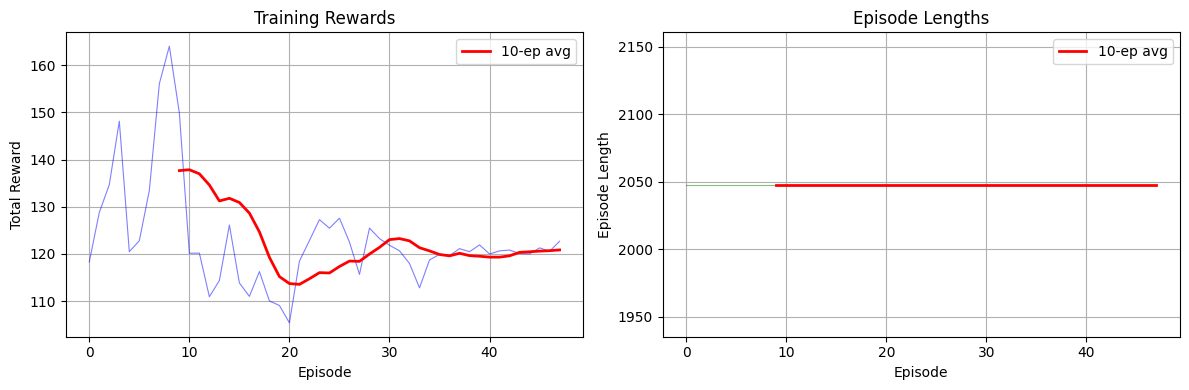

In [10]:
# =============================================================================
# Plot Training Progress
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Episode rewards
ax1 = axes[0]
ax1.plot(episode_rewards, 'b-', alpha=0.5, linewidth=0.8)
window = 10
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(episode_rewards)), smoothed, 'r-', linewidth=2, label=f'{window}-ep avg')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Rewards')
ax1.legend()
ax1.grid(True)

# Episode lengths
ax2 = axes[1]
ax2.plot(episode_lengths, 'g-', alpha=0.5, linewidth=0.8)
if len(episode_lengths) >= window:
    smoothed_len = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
    ax2.plot(range(window-1, len(episode_lengths)), smoothed_len, 'r-', linewidth=2, label=f'{window}-ep avg')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')
ax2.set_title('Episode Lengths')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [11]:
# =============================================================================
# Plot ASD of In-Loop Error Signal (True Residual Pitch) + RMS (0-3 Hz)
# =============================================================================

from scipy.integrate import cumulative_trapezoid

# Compute ASD of true pitch (in-loop error signal)
nperseg_asd = min(512, len(pitch_true)//4)
freq_error, psd_error = welch(pitch_true, fs, nperseg=nperseg_asd)
error_asd = np.sqrt(psd_error)

# Compute integrated RMS from 0 to 3 Hz
# RMS = sqrt(integral of PSD from f1 to f2)
# We integrate from low frequency up to 3 Hz
mask_3hz = freq_error <= 3.0
freq_band = freq_error[mask_3hz]
psd_band = psd_error[mask_3hz]

# Cumulative RMS integration (from 0 Hz upward)
cumulative_rms_sq = cumulative_trapezoid(psd_band, freq_band, initial=0)
cumulative_rms = np.sqrt(cumulative_rms_sq)

# Total RMS from 0-3 Hz
rms_0_3hz = cumulative_rms[-1] if len(cumulative_rms) > 0 else 0

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot ASD
ax.loglog(freq_error, error_asd, 'b-', linewidth=1.5, label='In-Loop Error ASD')
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('ASD (rad/√Hz)', fontsize=12, color='b')
ax.tick_params(axis='y', labelcolor='b')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.set_xlim([freq_error[1], fs/2])  # Start from first non-zero freq

# Add second y-axis for cumulative RMS
ax2 = ax.twinx()
ax2.semilogx(freq_band, cumulative_rms, 'r-', linewidth=2, label='Cumulative RMS')
ax2.set_ylabel('Cumulative RMS (rad)', fontsize=12, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Mark the 3 Hz point and RMS value
ax.axvline(3.0, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='3 Hz')
ax2.axhline(rms_0_3hz, color='r', linestyle=':', linewidth=1.5, alpha=0.7)

# Add annotation for RMS at 3 Hz
ax2.annotate(f'RMS(0-3 Hz) = {rms_0_3hz:.3e} rad\n= {rms_0_3hz*1e9:.3f} nrad',
             xy=(3.0, rms_0_3hz), xytext=(10, rms_0_3hz * 1.5),
             fontsize=11, color='r',
             arrowprops=dict(arrowstyle='->', color='r', alpha=0.7))

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax.set_title(f'In-Loop Error Signal (True Residual Pitch Motion)\nIntegrated RMS (0-3 Hz): {rms_0_3hz:.3e} rad = {rms_0_3hz*1e9:.3f} nrad',
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 60)
print("In-Loop Error Signal Summary")
print("=" * 60)
print(f"Integrated RMS (0-3 Hz): {rms_0_3hz:.3e} rad = {rms_0_3hz*1e9:.4f} nrad")
print(f"Total RMS (time-domain): {np.std(pitch_true):.3e} rad = {np.std(pitch_true)*1e9:.4f} nrad")

NameError: name 'pitch_true' is not defined

In [12]:
# =============================================================================
# Evaluation: Run Trained Agent and Collect Data
# =============================================================================

n_eval_steps = 4096  # Longer evaluation for better spectral resolution
env.max_steps = n_eval_steps

obs, _ = env.reset()
done = False

while not done:
    action = mpo.policy.get_action(
        torch.FloatTensor(obs).unsqueeze(0).to(device),
        deterministic=True
    )[0]
    
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

# Extract histories from environment
pitch_true = np.array(env.pitch_true_history)
pitch_measured = np.array(env.pitch_measured_history)
torque = np.array(env.torque_history)
seismic = np.array(env.seismic_history)
sensor_noise = np.array(env.sensor_noise_history)

print("=" * 60)
print("Evaluation Complete")
print("=" * 60)
print(f"Total steps: {len(pitch_true)}")
print(f"Duration: {len(pitch_true)/fs:.2f} s")
print(f"True pitch RMS: {np.std(pitch_true):.3e} rad")
print(f"Measured pitch RMS: {np.std(pitch_measured):.3e} rad")
print(f"Seismic noise RMS: {np.std(seismic):.3e}")
print(f"Sensor noise RMS: {np.std(sensor_noise):.3e} rad")

Evaluation Complete
Total steps: 3509
Duration: 13.71 s
True pitch RMS: 2.123e-06 rad
Measured pitch RMS: 2.123e-06 rad
Seismic noise RMS: 1.991e-08
Sensor noise RMS: 4.686e-13 rad


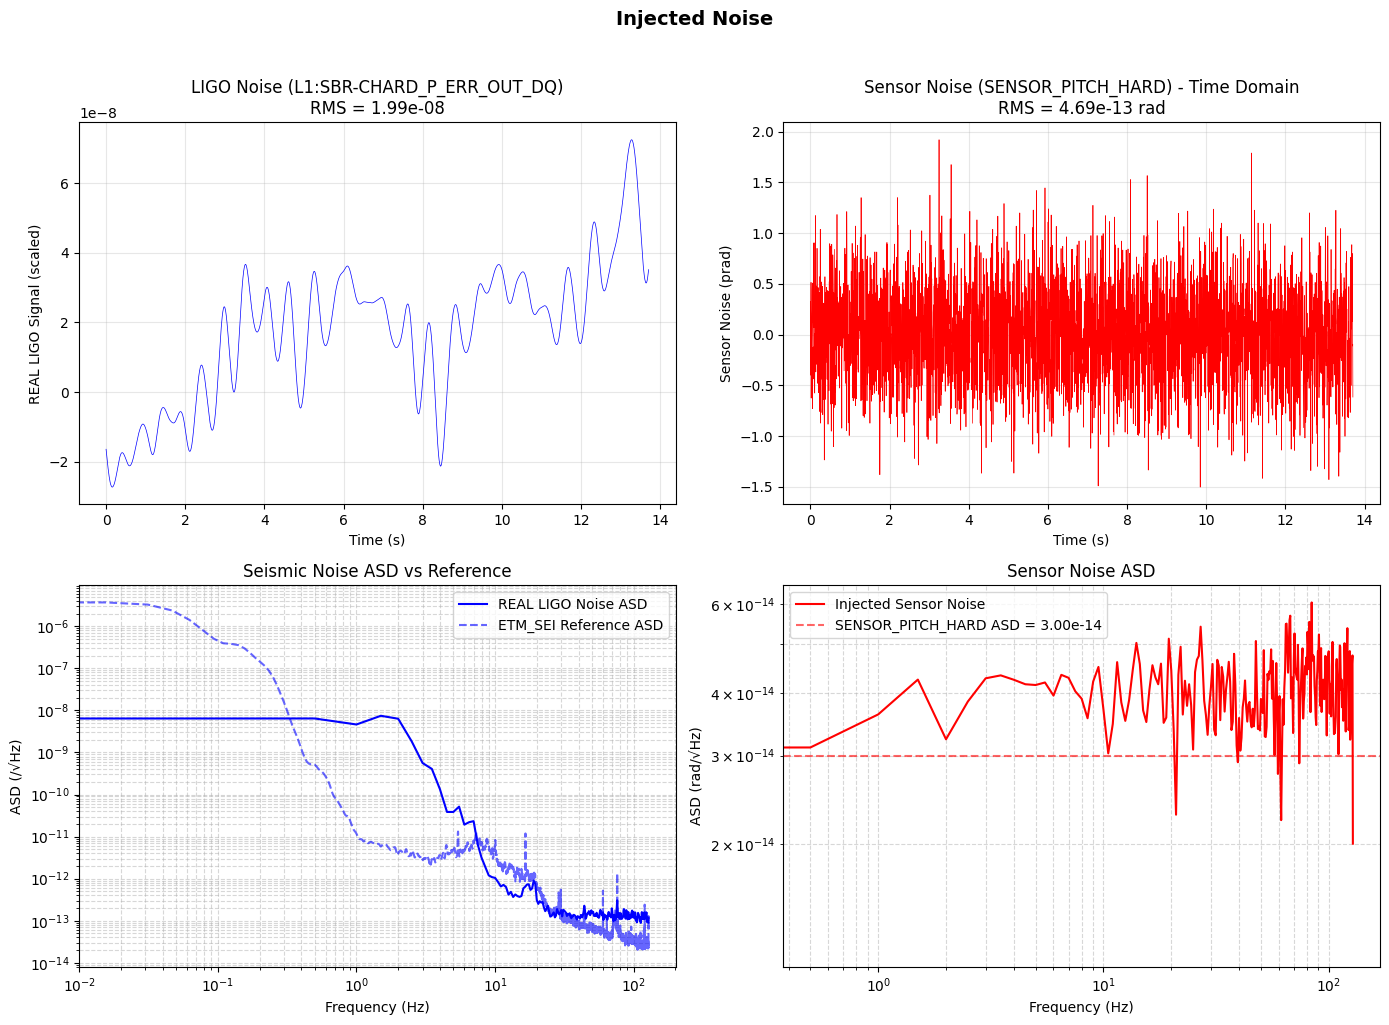


Noise Injection Summary

*** SEISMIC NOISE: REAL LIGO DATA ***
  Source: L1_1407160711.hdf5
  Channel: L1:SBR-CHARD_P_ERR_OUT_DQ
  Original sample rate: 2048 Hz (resampled to 256 Hz)
  Injection: Process disturbance (added to control input)
  Time-domain RMS: 1.991e-08

Sensor Noise (SENSOR_PITCH_HARD):
  Injection: Output measurement (additive)
  ASD level: 3.000e-14 rad/√Hz
  Time-domain RMS: 4.686e-13 rad


In [13]:
# =============================================================================
# Plot REAL Seismic Noise and Sensor Noise (Time Domain & ASD)
# =============================================================================

t = np.arange(len(seismic)) / fs
nperseg = min(512, len(seismic)//4)

# Compute ASDs
freq_seismic, psd_seismic = welch(seismic, fs, nperseg=nperseg)
seismic_asd = np.sqrt(psd_seismic)

freq_sensor, psd_sensor = welch(sensor_noise, fs, nperseg=nperseg)
sensor_asd = np.sqrt(psd_sensor)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# REAL seismic noise time domain
ax1 = axes[0, 0]
ax1.plot(t, seismic, 'b-', linewidth=0.5)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('REAL LIGO Signal (scaled)')
ax1.set_title(f'LIGO Noise (L1:SBR-CHARD_P_ERR_OUT_DQ)\nRMS = {np.std(seismic):.2e}')
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Sensor noise time domain
ax2 = axes[0, 1]
ax2.plot(t, sensor_noise * 1e12, 'r-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Sensor Noise (prad)')
ax2.set_title(f'Sensor Noise (SENSOR_PITCH_HARD) - Time Domain\nRMS = {np.std(sensor_noise):.2e} rad')
ax2.grid(True, alpha=0.3)

# REAL seismic noise ASD
ax3 = axes[1, 0]
ax3.loglog(freq_seismic, seismic_asd, 'b-', linewidth=1.5, label='REAL LIGO Noise ASD')
ax3.loglog(freq_sei_asd, sei_asd_ref, 'b--', linewidth=1.5, alpha=0.6, label='ETM_SEI Reference ASD')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('ASD (/√Hz)')
ax3.set_title('Seismic Noise ASD vs Reference')
ax3.legend()
ax3.grid(True, which='both', linestyle='--', alpha=0.5)

# Sensor noise ASD
ax4 = axes[1, 1]
ax4.loglog(freq_sensor, sensor_asd, 'r-', linewidth=1.5, label='Injected Sensor Noise')
ax4.axhline(sensor_noise_level, color='r', linestyle='--', linewidth=1.5, alpha=0.6, 
            label=f'SENSOR_PITCH_HARD ASD = {sensor_noise_level:.2e}')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('ASD (rad/√Hz)')
ax4.set_title('Sensor Noise ASD')
ax4.legend()
ax4.grid(True, which='both', linestyle='--', alpha=0.5)

plt.suptitle('Injected Noise', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Noise Injection Summary")
print("=" * 60)
print(f"\n*** SEISMIC NOISE: REAL LIGO DATA ***")
print(f"  Source: L1_1407160711.hdf5")
print(f"  Channel: L1:SBR-CHARD_P_ERR_OUT_DQ")
print(f"  Original sample rate: 2048 Hz (resampled to 256 Hz)")
print(f"  Injection: Process disturbance (added to control input)")
print(f"  Time-domain RMS: {np.std(seismic):.3e}")
print(f"\nSensor Noise (SENSOR_PITCH_HARD):")
print(f"  Injection: Output measurement (additive)")
print(f"  ASD level: {sensor_noise_level:.3e} rad/√Hz")
print(f"  Time-domain RMS: {np.std(sensor_noise):.3e} rad")

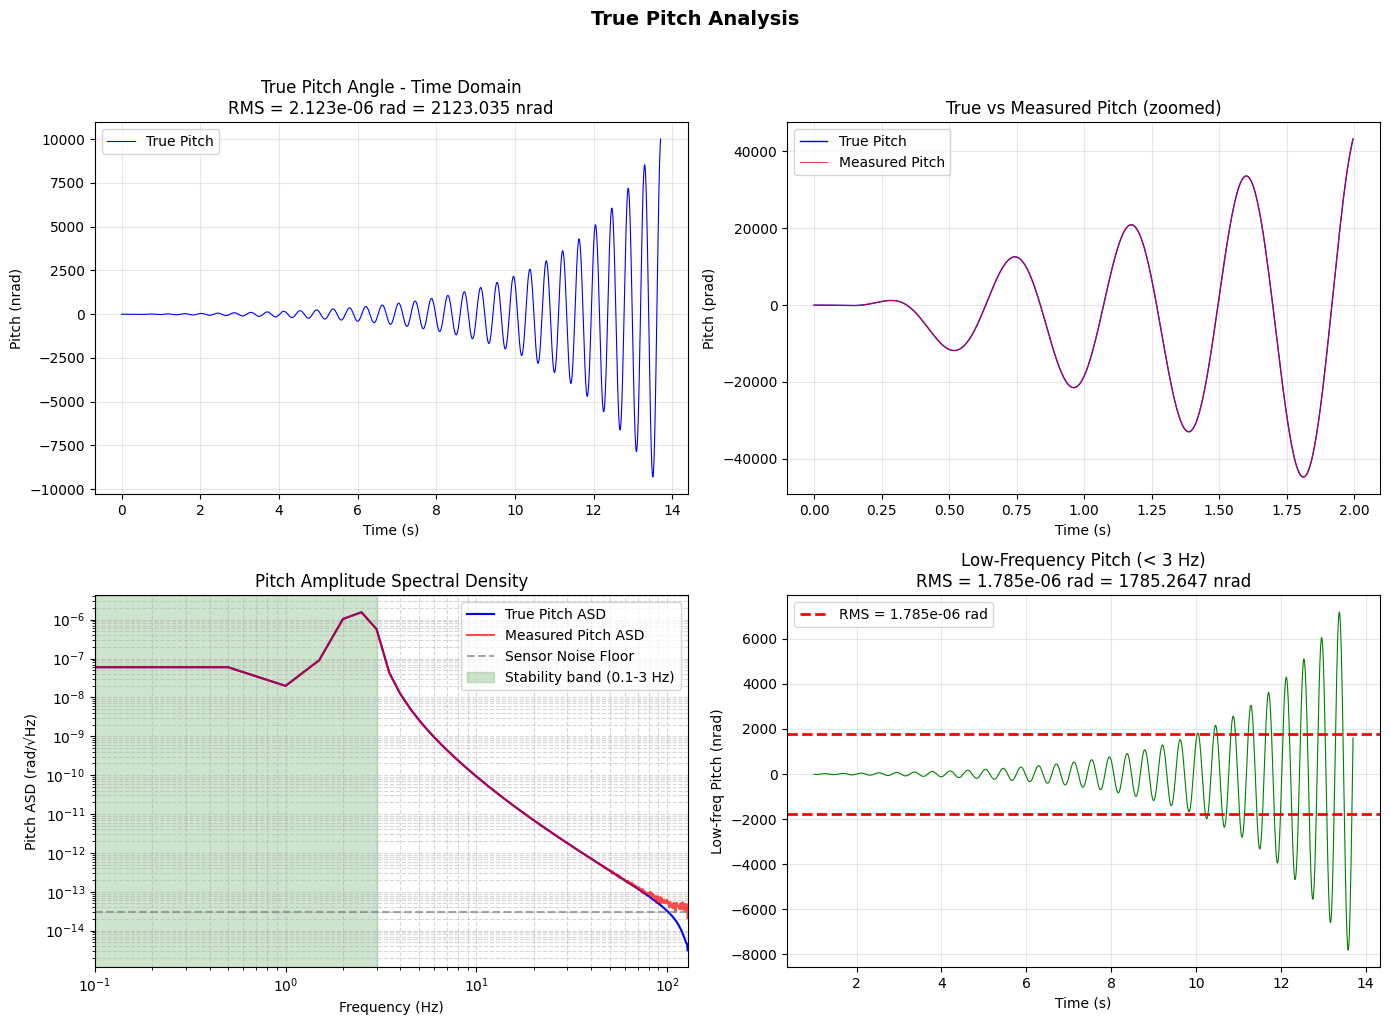


Pitch RMS Summary

True Pitch:
  Total RMS: 2.123e-06 rad = 2123.035 nrad
  Low-freq RMS (< 3 Hz): 1.785e-06 rad = 1785.2647 nrad

Measured Pitch:
  Total RMS: 2.123e-06 rad = 2123.035 nrad


In [14]:
# =============================================================================
# Plot True Pitch: Time Domain and ASD
# =============================================================================

# Compute ASD of true pitch
freq_pitch, psd_pitch = welch(pitch_true, fs, nperseg=nperseg)
pitch_asd = np.sqrt(psd_pitch)

# Compute ASD of measured pitch
freq_measured, psd_measured = welch(pitch_measured, fs, nperseg=nperseg)
measured_asd = np.sqrt(psd_measured)

# Calculate RMS values
pitch_rms = np.std(pitch_true)
measured_rms = np.std(pitch_measured)

# Low-frequency RMS (0.1-3 Hz for stability)
b_lf, a_lf = butter(2, 3.0 / (fs/2), btype='low')
pitch_lowfreq = lfilter(b_lf, a_lf, pitch_true)
# Discard transient
transient_samples = int(fs * 1.0)  # 1 second transient
pitch_lowfreq_rms = np.std(pitch_lowfreq[transient_samples:])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# True pitch time domain
ax1 = axes[0, 0]
ax1.plot(t, pitch_true * 1e9, 'b-', linewidth=0.8, label='True Pitch')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pitch (nrad)')
ax1.set_title(f'True Pitch Angle - Time Domain\nRMS = {pitch_rms:.3e} rad = {pitch_rms*1e9:.3f} nrad')
ax1.grid(True, alpha=0.3)
ax1.legend()

# True vs Measured pitch (zoomed)
ax2 = axes[0, 1]
t_zoom = slice(0, min(512, len(t)))
ax2.plot(t[t_zoom], pitch_true[t_zoom] * 1e12, 'b-', linewidth=1, label='True Pitch')
ax2.plot(t[t_zoom], pitch_measured[t_zoom] * 1e12, 'r-', linewidth=0.7, alpha=0.8, label='Measured Pitch')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pitch (prad)')
ax2.set_title('True vs Measured Pitch (zoomed)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Pitch ASD
ax3 = axes[1, 0]
ax3.loglog(freq_pitch, pitch_asd, 'b-', linewidth=1.5, label='True Pitch ASD')
ax3.loglog(freq_measured, measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='Measured Pitch ASD')
ax3.axhline(sensor_noise_level, color='gray', linestyle='--', alpha=0.7, label='Sensor Noise Floor')
ax3.axvspan(0.1, 3, alpha=0.2, color='green', label='Stability band (0.1-3 Hz)')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Pitch ASD (rad/√Hz)')
ax3.set_title('Pitch Amplitude Spectral Density')
ax3.legend()
ax3.grid(True, which='both', linestyle='--', alpha=0.5)
ax3.set_xlim([0.1, fs/2])

# Low-frequency pitch (band-limited)
ax4 = axes[1, 1]
ax4.plot(t[transient_samples:], pitch_lowfreq[transient_samples:] * 1e9, 'g-', linewidth=0.8)
ax4.axhline(pitch_lowfreq_rms * 1e9, color='r', linestyle='--', linewidth=2, 
            label=f'RMS = {pitch_lowfreq_rms:.3e} rad')
ax4.axhline(-pitch_lowfreq_rms * 1e9, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Low-freq Pitch (nrad)')
ax4.set_title(f'Low-Frequency Pitch (< 3 Hz)\nRMS = {pitch_lowfreq_rms:.3e} rad = {pitch_lowfreq_rms*1e9:.4f} nrad')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('True Pitch Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Pitch RMS Summary")
print("=" * 60)
print(f"\nTrue Pitch:")
print(f"  Total RMS: {pitch_rms:.3e} rad = {pitch_rms*1e9:.3f} nrad")
print(f"  Low-freq RMS (< 3 Hz): {pitch_lowfreq_rms:.3e} rad = {pitch_lowfreq_rms*1e9:.4f} nrad")
print(f"\nMeasured Pitch:")
print(f"  Total RMS: {measured_rms:.3e} rad = {measured_rms*1e9:.3f} nrad")

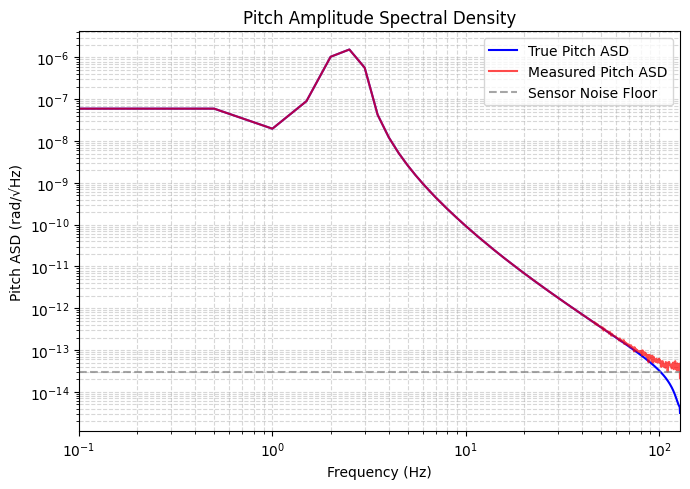

In [15]:
plt.figure(figsize=(7, 5))
plt.loglog(freq_pitch, pitch_asd, 'b-', linewidth=1.5, label='True Pitch ASD')
plt.loglog(freq_measured, measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='Measured Pitch ASD')
plt.axhline(sensor_noise_level, color='gray', linestyle='--', alpha=0.7, label='Sensor Noise Floor')
# plt.axvspan(0.1, 3, alpha=0.2, color='green', label='Stability band (0.1–3 Hz)')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Pitch ASD (rad/√Hz)')
plt.title('Pitch Amplitude Spectral Density')
plt.xlim([0.1, fs / 2])
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# =============================================================================
# Strain Sensitivity Calculation
# =============================================================================

# LIGO parameters (same as original notebook)
L_arm = 4000  # LIGO arm length in meters
pitch_to_length_coupling = 1e-8  # m/rad (typical coupling for LIGO)

# Conversion factor: strain = (pitch_angle × coupling_factor) / L_arm
pitch_to_strain_factor = pitch_to_length_coupling / L_arm

# Convert pitch ASD to strain ASD
strain_asd = pitch_asd * pitch_to_strain_factor
strain_measured_asd = measured_asd * pitch_to_strain_factor

# Calculate strain RMS
strain_rms = pitch_rms * pitch_to_strain_factor
strain_measured_rms = measured_rms * pitch_to_strain_factor
strain_lowfreq_rms = pitch_lowfreq_rms * pitch_to_strain_factor

# Load A+ sensitivity curve for comparison
aplus_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/noise_inputs/aicReferenceData_Aplus.txt'
try:
    aplus_data = np.loadtxt(aplus_path)
    aplus_freq = aplus_data[:, 0]
    aplus_strain = aplus_data[:, 4]  # Total noise curve
    has_aplus = True
except:
    has_aplus = False
    print("Note: A+ reference data not found")

print("=" * 60)
print("Strain Sensitivity Calculation")
print("=" * 60)
print(f"\nLIGO Parameters:")
print(f"  Arm length: {L_arm} m")
print(f"  Pitch-to-length coupling: {pitch_to_length_coupling:.1e} m/rad")
print(f"  Conversion factor: {pitch_to_strain_factor:.2e} strain/rad")

print(f"\nStrain RMS Values:")
print(f"  From true pitch:     {strain_rms:.3e}")
print(f"  From measured pitch: {strain_measured_rms:.3e}")
print(f"  Low-freq (< 3 Hz):   {strain_lowfreq_rms:.3e}")

Strain Sensitivity Calculation

LIGO Parameters:
  Arm length: 4000 m
  Pitch-to-length coupling: 1.0e-08 m/rad
  Conversion factor: 2.50e-12 strain/rad

Strain RMS Values:
  From true pitch:     5.308e-18
  From measured pitch: 5.308e-18
  Low-freq (< 3 Hz):   4.463e-18


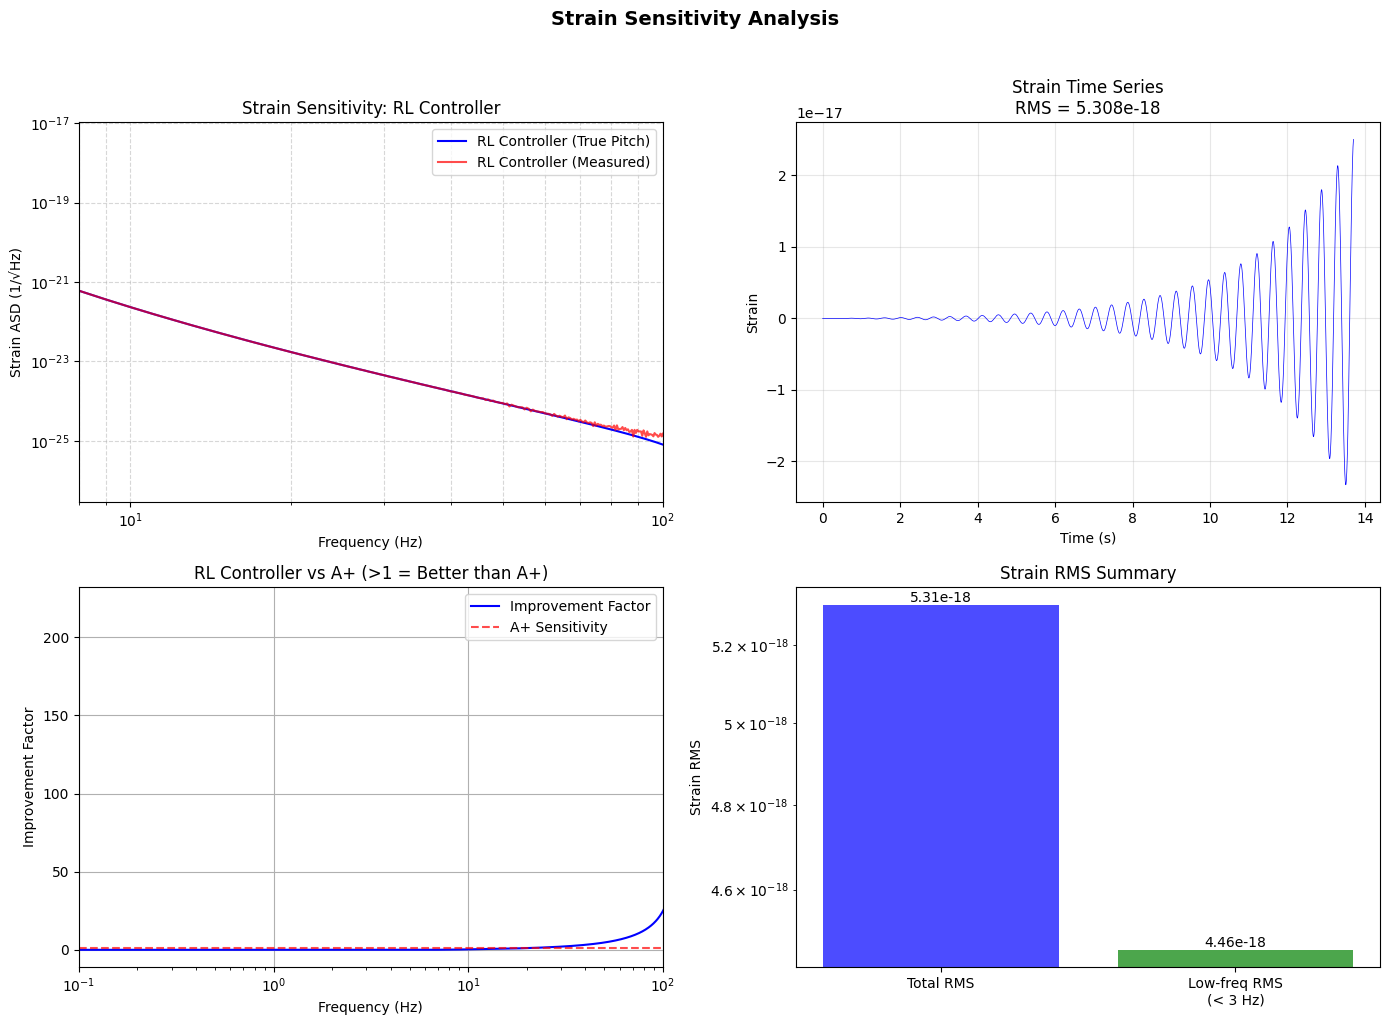


FINAL RESULTS SUMMARY

┌──────────────────────────────────────────────────────────┐
│                       PITCH ANGLE                        │
├──────────────────────────────────────────────────────────┤
│  Total RMS:            2.123e-06 rad = 2123.0354 nrad │
│  Low-freq RMS:         1.785e-06 rad = 1785.2647 nrad │
├──────────────────────────────────────────────────────────┤
│                    STRAIN SENSITIVITY                    │
├──────────────────────────────────────────────────────────┤
│  Total RMS:            5.308e-18                       │
│  Low-freq RMS:         4.463e-18                       │
├──────────────────────────────────────────────────────────┤
│                     NOISE INJECTION                      │
├──────────────────────────────────────────────────────────┤
│  Seismic RMS:          1.991e-08                       │
│  Sensor noise RMS:     4.686e-13 rad                  │
└──────────────────────────────────────────────────────────┘


In [17]:
# =============================================================================
# Plot Strain Sensitivity
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Strain ASD comparison
ax1 = axes[0, 0]
ax1.loglog(freq_pitch, strain_asd, 'b-', linewidth=1.5, label='RL Controller (True Pitch)')
ax1.loglog(freq_measured, strain_measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='RL Controller (Measured)')
# if has_aplus:
#     ax1.loglog(aplus_freq, aplus_strain, 'k--', linewidth=2, alpha=0.7, label='A+ Design Sensitivity')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Strain ASD (1/√Hz)')
ax1.set_title('Strain Sensitivity: RL Controller')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax1.set_xlim([8, 100])

# Strain time series
strain_timeseries = pitch_true * pitch_to_strain_factor
ax2 = axes[0, 1]
ax2.plot(t, strain_timeseries, 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Strain')
ax2.set_title(f'Strain Time Series\nRMS = {strain_rms:.3e}')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Improvement factor (if A+ data available)
ax3 = axes[1, 0]
if has_aplus:
    aplus_interp = np.interp(freq_pitch, aplus_freq, aplus_strain)
    improvement = aplus_interp / strain_asd
    ax3.semilogx(freq_pitch, improvement, 'b-', linewidth=1.5, label='Improvement Factor')
    ax3.axhline(1, color='red', linestyle='--', alpha=0.7, label='A+ Sensitivity')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Improvement Factor')
    ax3.set_title('RL Controller vs A+ (>1 = Better than A+)')
    ax3.legend()
    ax3.grid(True)
    ax3.set_xlim([0.1, 100])
else:
    ax3.text(0.5, 0.5, 'A+ Reference Data Not Available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Improvement Factor')

# Summary bar chart
ax4 = axes[1, 1]
labels = ['Total RMS', 'Low-freq RMS\n(< 3 Hz)']
values = [strain_rms, strain_lowfreq_rms]
colors = ['blue', 'green']
bars = ax4.bar(labels, values, color=colors, alpha=0.7)
ax4.set_ylabel('Strain RMS')
ax4.set_title('Strain RMS Summary')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val:.2e}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Strain Sensitivity Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\n┌{'─'*58}┐")
print(f"│{'PITCH ANGLE':^58}│")
print(f"├{'─'*58}┤")
print(f"│  Total RMS:         {pitch_rms:>12.3e} rad = {pitch_rms*1e9:>8.4f} nrad │")
print(f"│  Low-freq RMS:      {pitch_lowfreq_rms:>12.3e} rad = {pitch_lowfreq_rms*1e9:>8.4f} nrad │")
print(f"├{'─'*58}┤")
print(f"│{'STRAIN SENSITIVITY':^58}│")
print(f"├{'─'*58}┤")
print(f"│  Total RMS:         {strain_rms:>12.3e}                       │")
print(f"│  Low-freq RMS:      {strain_lowfreq_rms:>12.3e}                       │")
print(f"├{'─'*58}┤")
print(f"│{'NOISE INJECTION':^58}│")
print(f"├{'─'*58}┤")
print(f"│  Seismic RMS:       {np.std(seismic):>12.3e}                       │")
print(f"│  Sensor noise RMS:  {np.std(sensor_noise):>12.3e} rad                  │")
print(f"└{'─'*58}┘")

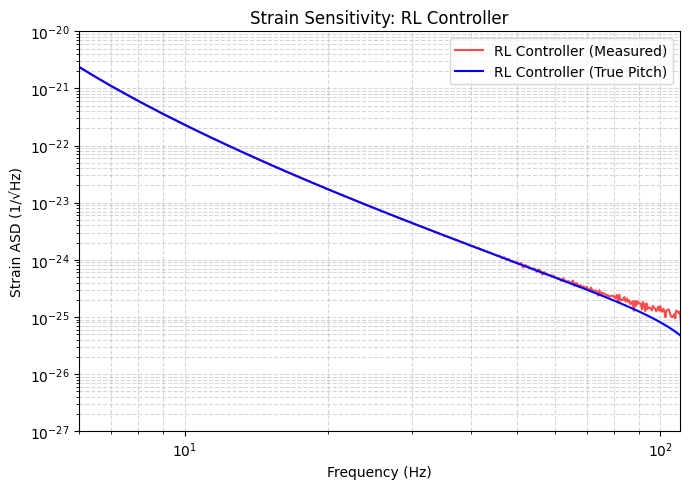

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.loglog(freq_measured, strain_measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='RL Controller (Measured)')
plt.loglog(freq_pitch, strain_asd, 'b-', linewidth=1.5, label='RL Controller (True Pitch)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain ASD (1/√Hz)')
plt.title('Strain Sensitivity: RL Controller')
plt.xlim([6, 110])
plt.ylim([1e-27, 1e-20])
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
